# Homework 2 : 單光子電腦斷層掃描的多類別分類
在這份作業中，請各位將 TODO 填寫好。

1. 調整適當的參數。
2. 將 validation 空白處填起來讓程式能夠運作
3. 寫出當 mode = valid、test 的 getitem()。
4. split the training dataset。
5. 調整適當的 optimizer、scheduler，雖然不一定會比較好，但可以嘗試看看。
6. 畫出 train 跟 valid 的 Misclassification Rate 圖。
7. 用相似的手法建立 Resnet, VIT model 架構。
8. 在 testing 裡填空格。
9. 填寫 test_dataset、test_loader、model 三個空格。
10. 挑選你認為最好的 model 並將預測結果輸出在 submission.csv。

kaggle rule:
1. 不得使用兩隻以上的帳號繳交 submission檔案 (可參加但不可丟答案)
2. team的名稱記得一定要改成學號

## Import Packages

In [1]:
# torchsummary 可以讓模型視覺化，以及匯出模型每層的詳細數量和每層的比例。
!pip install torchsummary

In [3]:
import pydicom
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

## Configuration

In [4]:
# TODO_1: 調整適當的參數(除了 num_classes，你可以任意調整以下的超參數)

class config:
    
    root = "/kaggle/input/2024dl"
    batch_size = 16
    lr = 1e-4
    epochs = 100
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)

device: cuda


## Input Data

In [5]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


In [6]:
train_data['Stage'].value_counts().sort_index()

Stage
1    44
2    42
3    75
Name: count, dtype: int64

## Defined functions

In [7]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    # 作用是啟用 batch normalization 和 dropout。
    # 保證 BN 層能夠用到每個 batch 資料的平均值和變異數。對於 Dropout 是隨機取一部分網路連線來訓練更新參數。
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        # Pytorch 中的分類損失函數（如 CrossEntropyLoss）期望 label 為 0 開始的整數。
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    
    scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass


def validation(model, valid_loader, criterion, device):
    # 確保 BN 層能夠用全部訓練資料的平均值和變異數，即驗證過程中要保證 BN 層的平均值和變異數不變。對於 Dropout 是利用了所有網路連接，即不進行隨機捨棄神經元。
    # pytorch 會自動把 BN 和 DropOut 固定住，不會取平均，而是用訓練好的數值。
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    # TODO_2: 請將空白處填起來讓程式能夠運作。

    # 這邊禁用 PyTorch 梯度的自動計算，因為在 validation 階段我們不需要更新 model 的權重，因此不需要進行反向傳播(backpropagation)和梯度計算。
    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = 
            ages = 
            genders = 
            labels = 

            logits = 
            labels = 
            loss = 

            valid_loss += 
            preds = 

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= 

        predictions = 
        ground_truths = 
        
        valid_acc, valid_f1, valid_misclass = 
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass

## Transformation

In [8]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min())/(image.max() - image.min())
        return changed_image

def build_transform(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    if is_train:
        # 若是包含 Random 系列的圖像增強，則只能加在train裡面
        t.append(v2.CenterCrop(size = (50, 50)))
        t.append(Normalization())
        return v2.Compose(t)
    
    t.append(v2.CenterCrop(size = (50, 50)))
    t.append(Normalization())
    return v2.Compose(t)

## Defined Dataset

In [9]:
class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode = None, transforms = None): # 將所有資料提出
        self.df = df
        self.mode = mode
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x): # 找出指定的資料
        
        age = torch.tensor(self.df.iloc[x, 1]) # 年齡
        gender = torch.tensor(self.df.iloc[x, 2]) # 性別
        index = torch.tensor(self.df.iloc[x, 4]) # 起始張數
        
        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]
        
        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5]) # 標籤
            if self.transforms: image = self.transforms(image)

            return image, age, gender, label
        
        
        # TODO_3: 寫出當 mode = valid、test 的 getitem()
        
        
        elif self.mode == "valid":
            

            return image, age, gender, label
    
        elif self.mode == "test":
            

            return image, age, gender

## Redefined VGG16

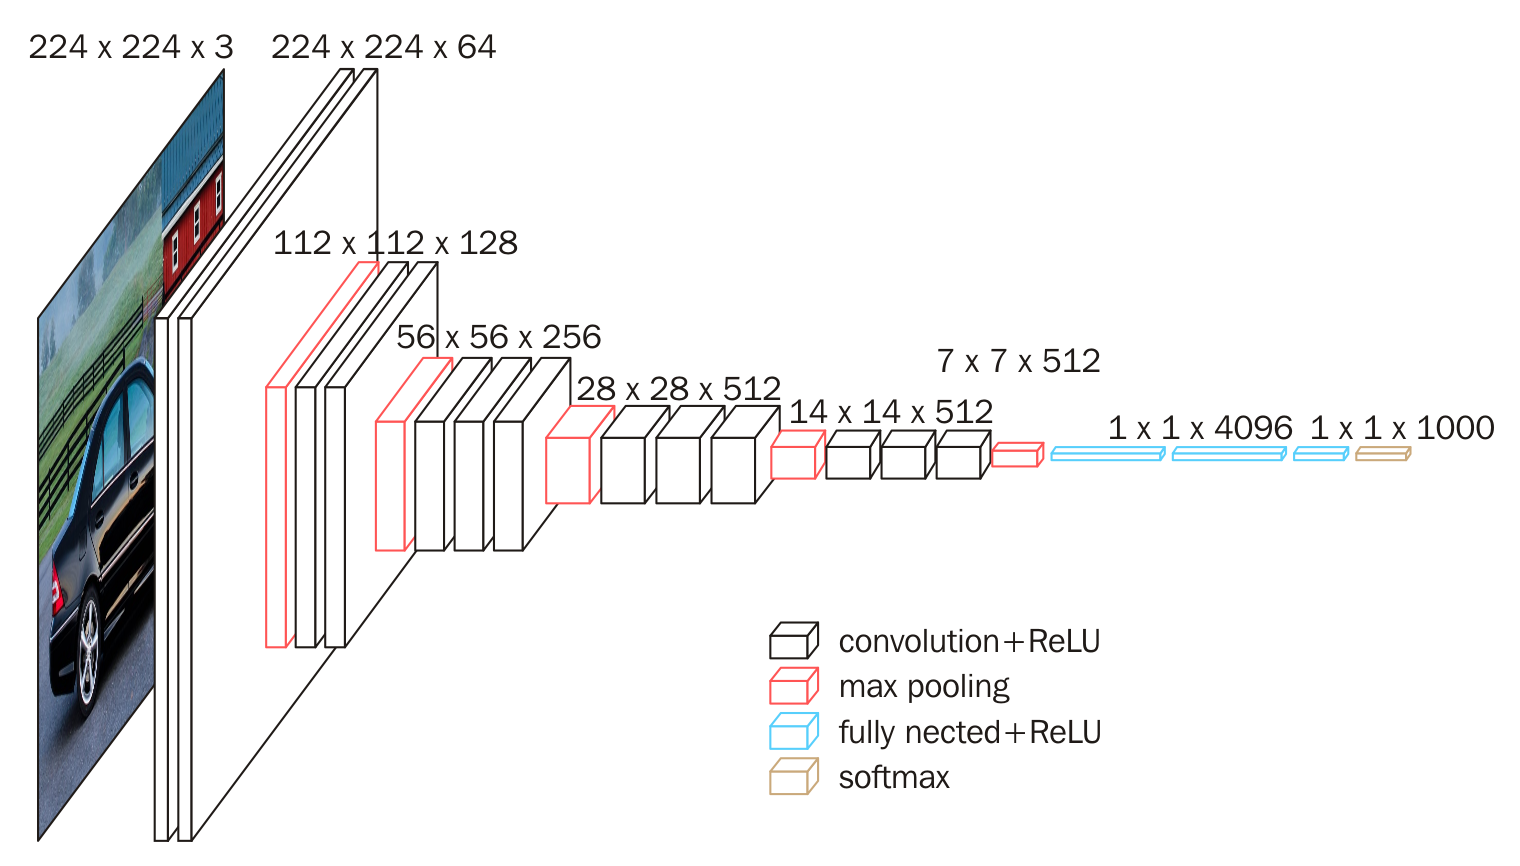

In [10]:
# VGG: Visual Geometry Group Network (視覺幾何群網絡)
# VGG16 的緣由: VGG 結構中有 13 個卷積層和 3 個全連接層

class VGGplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), features_grad = False): # 默認輸出為分到每一類的機率
        super().__init__()
        
        # 取出 vgg16 中的特徵層
        vgg16 = models.vgg16(weights = 'IMAGENET1K_V1', progress = True) # progress = True：顯示下載進度條。
        
        # nn.Identity() 是 Pytorch 中的特殊層，不會改變輸入，只是作為佔位符。這樣你以方便修改模型結構而不會影響其整體的輸出 size
        vgg16.features[30] = nn.Identity()
        
        # 將 VGG16 的輸出特徵圖壓縮 1x1，可以得到一個 512 維的特徵向量，便於與後面的 Fully Connected Layer 結合並處理輸入的不同尺寸的圖像。
        vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # 移除 VGG16 預設的分類器
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值: False/True
        # features_grad: 控制是否對 VGG16 的特徵提取層進行微調(參與梯度計算)
        # 因為資料量不大，因此將 param.requires_grad 設為 False，只訓練新的分類層，減少訓練時間和 overfitting 風險。
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
         
        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(512 + 2, num_classes) # 512: vgg16 特徵層結果, 2: age & gender
        )

    def forward(self, x, age, gender):
        output = self.backend(x)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim = 1) # output size = (batch_size, 512), age size = (batch_size), age.view(-1, 1) size = (batch_size, 1), dim = 1; columns concat
        outputs = self.classifier(outputs) # outputs size = (batch_size, 3), 3: labels
        return outputs

In [11]:
model = VGGplus(num_classes = 3)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s] 


VGGplus(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)
del model

總參數量: 14716233


## VGG16 Architecture Overview and Internal Functions

### 1. 導入 vgg16 的架構和 ImageNet 訓練出來的權重 (**transfer learning**)

In [13]:
vgg16 = models.vgg16(weights = 'IMAGENET1K_V1', progress = True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
total_params = sum(p.numel() for p in vgg16.parameters())
print("總參數量:", total_params)

總參數量: 138357544


以下簡單介紹 vgg16 中使用到的函式: (以下函式的輸入都需要四個維度: (N = number of data, C = number of channels, H = Height, W = Width))

> [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

> * 3: in_channels
> * 64: out_channels 
> * stride = (1, 1): kernel 的移動由左至右，由上至下，步長皆為1
> * padding = (1, 1): 在輸入的周圍填充一層0

> Note:
> * 雖然是 2d 的 convolution，但實際的輸入是和 kernel 都是 3 維陣列，而 2d 指的是 kernel 移動的方向。
> * 因為 1 個 (3, 3, 3) 的 kernel 和 1 個 bias 遍歷一次輸入就會產生一層輸出，這邊的輸出有64層，就需要 64 個 (3, 3, 3) 的 kernal 和對應的 64 個 bias。
> * 這樣的 stride 和 padding 的設定可以讓輸出和輸入的長寬不變。

![](https://discuss.pytorch.org/uploads/default/original/3X/6/0/60994f2ed1f8c34ee6e83741e2e87fca0a1b4655.jpeg)

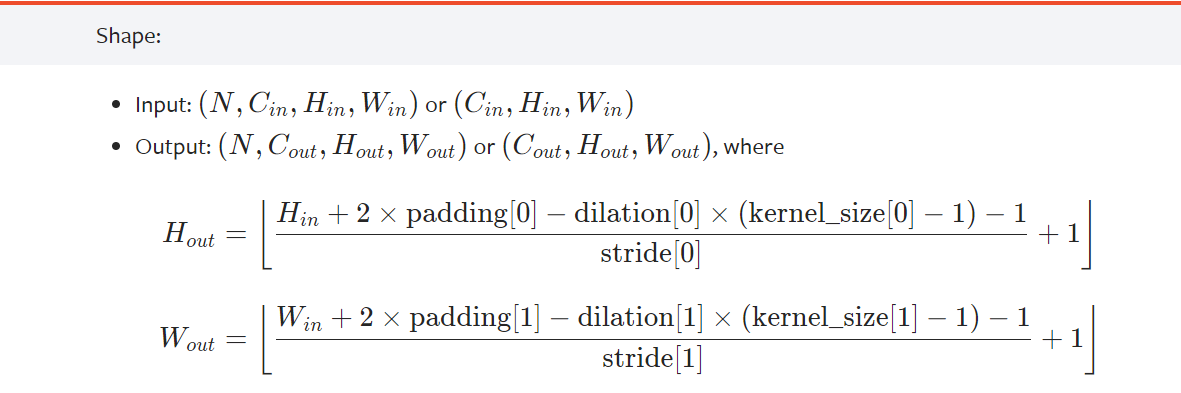

簡易算法:
1. 使用 **kernel_size**: H - kernel_size + 1
2. 使用 **kernel_size, stride**: (H - kernel_size) / stride + 1
3. 使用 **kernel_size, stride, padding**: (H + (2 * padding) - kernel_size) / stride + 1
4. 使用 **kernel_size, stride, padding, dilation**: (H + (2 * padding) - dilation * (kernel_size - 1) - 1) / stride + 1

In [15]:
m = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
print('2D convolutional layer: ', m, '\n')

input = torch.randn(1, 3, 50, 50)
print('input shape: ', input.shape)

output = m(input)
print('output shape: ', output.shape, '\n')


for i, param in enumerate(m.parameters()):
    if i == 0:
        print('weights: ', param.shape)
    else:
        print('bias: ', param.shape)

del m, input, output

2D convolutional layer:  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 

input shape:  torch.Size([1, 3, 50, 50])
output shape:  torch.Size([1, 64, 50, 50]) 

weights:  torch.Size([64, 3, 3, 3])
bias:  torch.Size([64])


> [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

> * ceil_mode: True = 將不足的邊用 NAN 補齊，False = 將不足的邊直接刪除

In [16]:
input = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3]]).reshape(1, 1, 3, 3).float()
print(input)

print("\nceil_mode = False")
m1 = nn.MaxPool2d(2, stride = 2, ceil_mode = False)
output1 = m1(input)
print(output1)

print("\nceil_mode = True")
m2 = nn.MaxPool2d(2, stride = 2, ceil_mode = True)
output2 = m2(input)
print(output2)

del m1, m2, input, output1, output2

tensor([[[[1., 1., 1.],
          [2., 2., 2.],
          [3., 3., 3.]]]])

ceil_mode = False
tensor([[[[2.]]]])

ceil_mode = True
tensor([[[[2., 2.],
          [3., 3.]]]])


> [AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)(output_size=(7, 7)) 

> 按照期望的輸出大小對輸入做平均

In [17]:
input = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3]]).reshape(1, 1, 3, 3).float()
print(input, '\n')

m7 = nn.AdaptiveAvgPool2d(output_size = (7, 7))
output = m7(input)
print(output, '\n')

m1 = nn.AdaptiveAvgPool2d(output_size = (1, 1))
output = m1(input)
print(output)

del input, m7, m1, output

tensor([[[[1., 1., 1.],
          [2., 2., 2.],
          [3., 3., 3.]]]]) 

tensor([[[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
          [2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000],
          [2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000],
          [3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000],
          [3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000]]]]) 

tensor([[[[2.]]]])


雖然 AdaptiveAvgPool2d() 的輸出大小可以大於輸入大小，但這種作法可能導致訊息的丟失。

### 2. 觀察 vgg16 的 Output Shape 去設計 feature layers 和 classifier layers 之間的連接層

In [18]:
# 因 summary() 的 input 存在GPU中, 要將 model 也移至 GPU 上才能運行
vgg16.to(config.device)
summary(vgg16, input_size = (3, 50, 50)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
              ReLU-2           [-1, 64, 50, 50]               0
            Conv2d-3           [-1, 64, 50, 50]          36,928
              ReLU-4           [-1, 64, 50, 50]               0
         MaxPool2d-5           [-1, 64, 25, 25]               0
            Conv2d-6          [-1, 128, 25, 25]          73,856
              ReLU-7          [-1, 128, 25, 25]               0
            Conv2d-8          [-1, 128, 25, 25]         147,584
              ReLU-9          [-1, 128, 25, 25]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

參數數量 = (Input features) × (Output features) + (Bias terms)  
Input features = 25,088 = 512×7×7, Output features = 4,096, Bias terms = 4,096   
所以，參數數量 = 25,088 × 4,096 + 4,096 = 102,760,192 + 4,096 = 102,764,288   
以上顯示的 102,764,544，比我們的計算多了 256 個參數。可能來自於 input features 數量的誤差，而這種誤差可能是由於不同的張量操作（如 padding、四捨五入）所引起的。

在 ReLU-30 得到的輸出大小已經是 (512, 3, 3)，如果使用模型中的 MaxPool2d-31: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, **ceil_mode=False**)，會有些資訊被忽略，所以接下來會更改 31 層和 32 層。

In [19]:
vgg16.features[30] = nn.Identity()
vgg16.avgpool = nn.AdaptiveAvgPool2d(1)
vgg16.classifier = nn.Identity()
summary(vgg16, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
              ReLU-2           [-1, 64, 50, 50]               0
            Conv2d-3           [-1, 64, 50, 50]          36,928
              ReLU-4           [-1, 64, 50, 50]               0
         MaxPool2d-5           [-1, 64, 25, 25]               0
            Conv2d-6          [-1, 128, 25, 25]          73,856
              ReLU-7          [-1, 128, 25, 25]               0
            Conv2d-8          [-1, 128, 25, 25]         147,584
              ReLU-9          [-1, 128, 25, 25]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

Note: 
* 在 avgpool 和 classifier 之間， vgg16 模型會把 (-1, 512, 1, 1) reshape 成 (-1, 512)。
* 每一個 (3, 50, 50) 的影像經過更改後的 vgg16 模型就會產生 512 個 feature 。

### 3. 增加影像之外的變數(ex. 性別, 年齡, ...)去建立 classifier layers

這裡想建立一個特徵層可以考慮剛剛影像經過特徵層所得到的 512 個數值和性別，年齡這兩個數值，所以分類層的一開始會有 512+2 = 514 個神經元。

In [20]:
del vgg16

Initializing model...
Epoch[1/100], Train Loss: 1.1368, Train Acc: 30.47%, Train F1: 23.35% | Valid Loss: 1.3256, Valid Acc: 57.58%, Valid F1: 42.47%, Valid Misclass: 42.42% | LR: 0.000004
Epoch[2/100], Train Loss: 1.0923, Train Acc: 50.78%, Train F1: 32.02% | Valid Loss: 1.2807, Valid Acc: 48.48%, Valid F1: 27.35%, Valid Misclass: 51.52% | LR: 0.000004
Epoch[3/100], Train Loss: 1.0675, Train Acc: 50.00%, Train F1: 28.76% | Valid Loss: 1.2470, Valid Acc: 45.45%, Valid F1: 21.28%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[4/100], Train Loss: 1.0454, Train Acc: 47.66%, Train F1: 23.30% | Valid Loss: 1.2182, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[5/100], Train Loss: 1.0255, Train Acc: 47.66%, Train F1: 23.30% | Valid Loss: 1.1931, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[6/100], Train Loss: 1.0101, Train Acc: 47.66%, Train F1: 23.30% | Valid Loss: 1.1676, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass

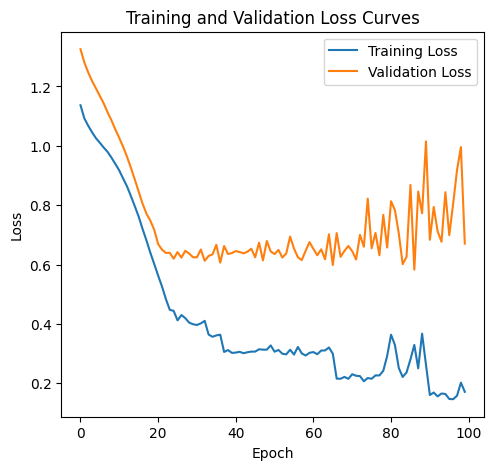

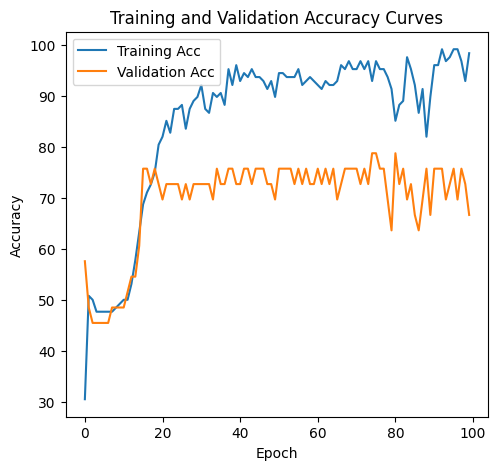

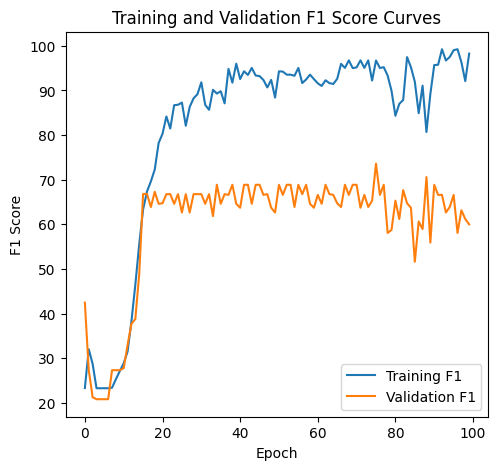

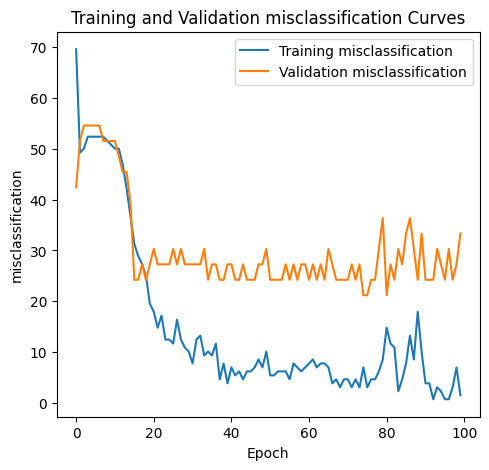

In [21]:
def main():
    seed_everything(config.seed)
    
    # train dataframe
    train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
    
    
    # TODO_4: split the training dataset，通常是 8:2，但可以嘗試其他的分法，e.g. 7:3。
    
    
    # split training & validation dataset 
    train_dataset, val_dataset = train_test_split(train_data, train_size = 0.8, test_size = 0.2, random_state = config.seed)

    train_dataset = ParkinsonsDataset(train_dataset, transforms = build_transform(True), mode = "train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms = build_transform(False), mode = "valid")
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False)
    

    # settings
    print("Initializing model...")
    
    model = VGGplus(num_classes = config.num_classes, features_grad = True)
    
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    # TODO_5: 調整適當的 optimizer、scheduler。
    
    optimizer = torch.optim.Adam(parameters, lr = config.lr, weight_decay = config.weight_decay) 
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")

        best_ckpt = torch.load("checkpoint.pth", map_location = config.device, weights_only = False)
        model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training misclassification')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation misclassification')
    plt.xlabel('Epoch')
    plt.ylabel('misclassification')
    plt.legend()
    plt.title('Training and Validation misclassification Curves')
    plt.show()
    
    
    # TODO_6: 畫出 train 跟 valid 的 Misclassification Rate 圖。
   
    

if __name__ == "__main__":
    main()

## Redefined Resnet


In [ ]:
# TODO_7: 用跟 VGG 類似的方式建立 Resnet

class ResNetplus(nn.Module):
    def __init__(self, num_classes, input_size = (3, 50, 50), features_grad = False):
        super().__init__()
        
        resnet50 = models.resnet50(weights = 'IMAGENET1K_V1', progress = True) # 這邊若想用其他 resnet 模型也行

        

## Redefined VIT

In [ ]:
# TODO_7: 建立 VIT(下次助教課會講到)




## testing

In [22]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad(): 
        for image, age, gender in test_loader:
            image = image.to(device = device, dtype = torch.float)
            age = age.to(device)
            gender = gender.to(device)
            logits = model(image, age, gender)
            pred = torch.argmax(logits, dim = 1)
            preds.append(pred)

    preds = torch.cat(preds)
    
    # TODO_8: 因為輸出的 preds為 0,1,2，所以請調整成 1,2,3。
    preds = 
    
    return preds
    
    

In [23]:
seed_everything(config.seed)
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

# TODO_9: 填寫 test_dataset、test_loader、model 四個空格，記得 test_loader 的 shuffle = False。

test_dataset = 
test_loader = 
model = 


model.to(config.device)

best_ckpt = torch.load(f"checkpoint.pth")
model.load_state_dict(best_ckpt["model"])

preds = testing(model, test_loader, config.device)

In [24]:
# TODO_10: 將 .csv 取名。

df = pd.read_csv(os.path.join(config.root, 'submission.csv'))
df = pd.DataFrame(df)
df['Stage'] = preds.cpu().numpy() # 將 preds 從 GPU 轉移到 CPU 並轉換為 NumPy 陣列
df.to_csv('.csv',index = False, header = True)